In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import math
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm,trange

from shutil import rmtree

from scipy.signal import savgol_filter

from numpy.linalg import inv

In [2]:
def get_angle(dx,dy,scale=5):
    dx = dx*scale
    dy = dy*scale

    angle = np.degrees(np.pi*2 + math.atan2(dy, dx))%360
    return angle

def get_xy(center,depth,P,c=0):
    
    center = np.array(center).reshape((1,2))
    depth = np.array(depth).reshape(1,1)

    return imagetocamera(center,depth,P)

def imagetocamera(points, depth, projection):
    """
    points: (N, 2), N points on X-Y image plane
    depths: (N,), N depth values for points
    projection: (3, 4), projection matrix
    corners: (N, 3), N points on X(right)-Y(down)-Z(front) camera coordinate
    """
    assert points.shape[1] == 2, "Shape ({}) not fit".format(points.shape)

    corners = np.hstack([points, np.ones(
        (points.shape[0], 1))]).dot(inv(projection[:, 0:3]).T)
    assert np.allclose(corners[:, 2], 1)
    corners *= depth.reshape(-1, 1)

    return list(corners[0])

def read_calib(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        P2 = np.array(lines[2].strip().split(' ')[1:], dtype=np.float32).reshape(3, 4)
        
    return P2

In [3]:
def smoothing(df,columns,window_size=17,order=3):
    if len(df) < window_size:
        window_size = len(df)
    
    if window_size <= order:
        return df
    
#     print(window_size,order)
    for col in columns:
        df[col] = savgol_filter(df[col], len(df), order, mode='interp')
        
    return df

In [4]:
BASE_DIR_calib = '/home/alfin/Documents/deep_learning/production/centernet_3d_fish/'
# BASE_DIR = BASE_DIR_calib
BASE_DIR = '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/'

IMG_DIR = os.path.join(BASE_DIR,'MADAI/')
INF_DIR = os.path.join(BASE_DIR,'label_inference/')
CALIB_DIR = os.path.join(BASE_DIR_calib,'data/')

data_path = [{'img':IMG_DIR+img,'inf':INF_DIR+inf
             } for img,inf in 
             zip(sorted(os.listdir(IMG_DIR)),
#                  sorted([x for x in os.listdir(INF_DIR) if not x.endswith('angle.txt')])
                 sorted([x for x in os.listdir(INF_DIR) if not x.endswith('smooth.txt')])
                )]
calib_path = os.path.join(CALIB_DIR,'000000.txt')

In [5]:
len(data_path)

300

In [6]:
img_input_size = (512,512)

inf_header = ['h','w','l','z','alphax','alphay','conf','idx','cx','cy','xmin','ymin','xmax','ymax','id']

all_data = []
for j,data in tqdm(enumerate(data_path[:])):

    ann = pd.read_csv(data['inf'],sep = ' ',names=inf_header)
    for i in range(len(ann)):
        label = ann.iloc[i]

        label_dict = label.to_dict()
        label_dict['filename'] = data['inf']
        all_data.append(label_dict)


300it [00:00, 458.00it/s]


In [7]:
df_input = pd.DataFrame(all_data)
# df_input = df_input.drop_duplicates(keep=False)
df_output = None

In [8]:
df = df_input[df_input['id']==2]
df = df.reset_index(drop=True)
df['idx'] = df.index
df

,h,w,l,z,alphax,alphay,conf,idx,cx,cy,xmin,ymin,xmax,ymax,id,filename
0,0.141378,0.064516,0.324518,2.052758,5.286292,5.830669,0.981605,0,184.0,216.0,159.0,205.0,207.0,225.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
1,0.133685,0.060886,0.306831,1.972449,0.508227,6.017398,0.956095,1,160.0,191.0,144.0,174.0,173.0,205.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
2,0.133685,0.060886,0.306831,1.972449,0.508227,6.017398,0.956095,2,160.0,191.0,144.0,174.0,173.0,205.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
3,0.147355,0.067304,0.338133,2.061810,2.009736,5.360841,0.954636,3,184.0,212.0,158.0,200.0,207.0,223.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
4,0.147355,0.067304,0.338133,2.061810,2.009736,5.360841,0.954636,4,184.0,212.0,158.0,200.0,207.0,223.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.132218,0.060435,0.303380,1.956338,5.686008,0.361227,0.955566,58,128.0,183.0,106.0,168.0,150.0,195.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
59,0.141465,0.064308,0.324923,1.385259,5.932164,5.523153,0.964956,59,128.0,223.0,108.0,202.0,149.0,239.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
60,0.141465,0.064308,0.324923,1.385259,5.932164,5.523153,0.964956,60,128.0,223.0,108.0,202.0,149.0,239.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
61,0.141465,0.064308,0.324923,1.385259,5.932164,5.523153,0.964956,61,128.0,223.0,108.0,202.0,149.0,239.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...


In [9]:
target = 'alphax'

In [10]:
# df['alphax'] = (df['alphax'] + 2*np.pi)%2*np.pi
# df['alphax'] = df['alphax'] - np.pi
# df['alphax'] = abs(df['alphax'])

# df['alphay'] = (df['alphay'] + 2*np.pi)%2*np.pi
# df['alphay'] = df['alphay'] - np.pi
# df['alphay'] = abs(df['alphay'])

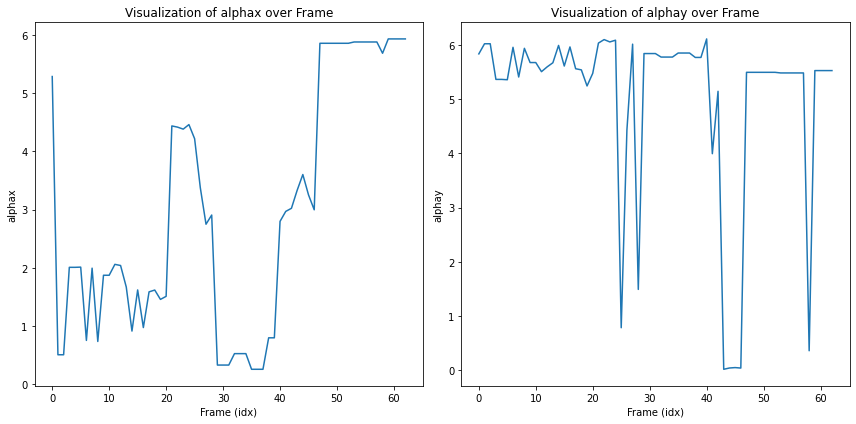

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 'alphax' on the first subplot
ax1.plot(df['idx'], df['alphax'])
ax1.set_xlabel('Frame (idx)')
ax1.set_ylabel('alphax')
ax1.set_title('Visualization of alphax over Frame')

# Plot 'alphay' on the second subplot
ax2.plot(df['idx'], df['alphay'])
ax2.set_xlabel('Frame (idx)')
ax2.set_ylabel('alphay')
ax2.set_title('Visualization of alphay over Frame')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [12]:
s = df_interpolated
d = pd.Series(s.values[1:,0] - s.values[:-1,0], index=s.index[:-1]).abs()

NameError: name 'df_interpolated' is not defined

In [13]:
ss = d>np.pi/4
ss = ss[ss==True]

NameError: name 'd' is not defined

In [192]:
ss

Series([], dtype: bool)

ConversionError: Failed to convert value(s) to axis units: array(['/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000000.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000001.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000002.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000003.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000004.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000005.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000006.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000007.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000008.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000009.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000010.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000011.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000012.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000013.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000014.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000015.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000016.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000017.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000018.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000019.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000020.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000021.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000022.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000023.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000024.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000025.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000026.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000027.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000028.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000029.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000030.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000031.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000032.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000033.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000034.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000035.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000036.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000037.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000038.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000039.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000040.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000041.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000042.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000043.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000044.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000045.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000046.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000047.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000048.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000049.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000050.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000051.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000052.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000053.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000054.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000055.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000056.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000057.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000058.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000059.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000060.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000061.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000062.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000063.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000064.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000065.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000066.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000067.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000068.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000069.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000070.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000071.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000072.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000073.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000074.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000075.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000076.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000077.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000078.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000079.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000080.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000081.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000082.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000083.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000084.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000085.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000086.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000087.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000088.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000089.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000090.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000091.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000092.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000093.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000094.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000095.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000096.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000097.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000098.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000099.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000100.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000101.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000102.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000103.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000104.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000105.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000106.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000107.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000108.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000109.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000110.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000111.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000112.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000113.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000114.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000115.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000116.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000117.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000118.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000119.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000120.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000121.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000122.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000123.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000124.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000125.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000126.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000127.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000128.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000129.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000130.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000131.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000132.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000133.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000134.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000135.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000136.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000137.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000138.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000139.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000140.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000141.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000142.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000143.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000144.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000145.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000146.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000147.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000148.txt',
       '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/label_inference/000149.txt'],
      dtype=object)

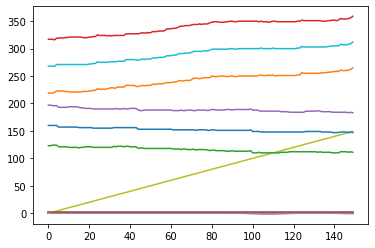

In [196]:
plt.plot(d>np.pi/4)
plt.plot(df_interpolated)
plt.show()

In [167]:
df.loc[ss.index,target] = None

In [168]:
df

,h,w,l,z,alphax,alphay,conf,idx,cx,cy,xmin,ymin,xmax,ymax,id,filename
0,0.158283,0.112746,0.369622,1.275099,1.048479,-0.115082,0.976184,0,268.0,160.0,219.0,123.0,317.0,197.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
1,0.156594,0.111519,0.365696,1.262812,0.995196,-0.130244,0.973892,1,268.0,160.0,219.0,123.0,317.0,197.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
2,0.155912,0.111082,0.364140,1.253697,0.879115,-0.138536,0.971505,2,268.0,160.0,219.0,124.0,317.0,196.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
3,0.155969,0.111126,0.364228,1.255956,0.782605,-0.120998,0.968486,3,268.0,160.0,220.0,124.0,316.0,196.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
4,0.153589,0.109580,0.358808,1.243714,0.784835,-0.101533,0.970618,4,271.0,160.0,223.0,124.0,319.0,196.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.157737,0.111930,0.368212,1.410591,-0.749564,0.054300,0.979060,145,307.0,148.0,260.0,112.0,354.0,184.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
146,0.157561,0.111815,0.368098,1.399571,-0.416966,0.057713,0.978284,146,307.0,148.0,260.0,112.0,354.0,184.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
147,0.156982,0.111426,0.366585,1.399292,-0.292909,0.043251,0.977276,147,308.0,147.0,261.0,111.0,355.0,183.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...
148,0.156566,0.111104,0.365926,1.398663,0.010701,0.033751,0.975299,148,309.0,148.0,262.0,112.0,356.0,184.0,2.0,/home/alfin/Documents/deep_learning/fish_conve...


In [178]:
# Set the 'idx' column as the DataFrame index

# df = df.reset_index(drop=True)

# Calculate the mean and standard deviation of 'alphax'
mean = df[target].mean()
std = df[target].std()

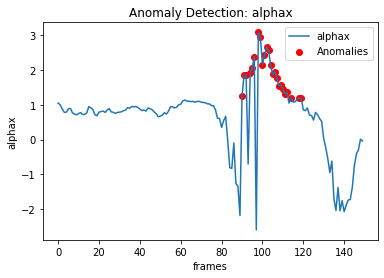

In [179]:
# Set the threshold for anomaly detection (e.g., 3 standard deviations from the mean)
threshold = mean + 0.5 * std

# Detect anomalies
anomalies = df[df[target] > threshold]

# Plot the 'alphax' values with anomalies highlighted
plt.plot(df.index, df[target], label=target)
plt.scatter(anomalies.index, anomalies[target], color='red', label='Anomalies')
plt.xlabel('frames')
plt.ylabel(target)
plt.title('Anomaly Detection: alphax')
plt.legend()
plt.show()

In [180]:
target

'alphax'

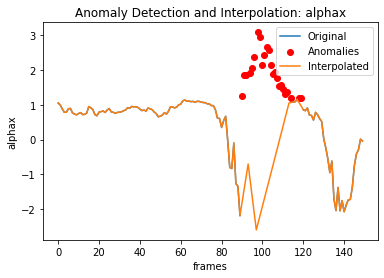

In [181]:
if anomalies.index[0] == 0:
    df.loc[anomalies.index[1:],target] = None
else:
    df.loc[anomalies.index,target] = None
    
df_cleaned = df

# Interpolate the missing values
df_interpolated = df_cleaned.interpolate()

# Plot the original 'alphax' values, removed anomalies, and interpolated data
plt.plot(df.index, df[target], label='Original')
plt.scatter(anomalies.index, anomalies[target], color='red', label='Anomalies')
plt.plot(df_interpolated.index, df_interpolated[target], label='Interpolated')
plt.xlabel('frames')
plt.ylabel(target)
plt.title('Anomaly Detection and Interpolation: alphax')
plt.legend()
plt.show()

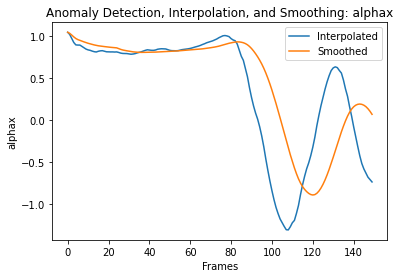

In [195]:
# Smooth the interpolated data using a rolling mean with window size 5 (adjust as needed)
smoothed_data = df_interpolated[target].rolling(window=25, min_periods=1).mean()

# Plot the original 'alphax' values, removed anomalies, interpolated data, and smoothed data
# plt.plot(df.index, df['alphax'], label='Original')
# plt.scatter(anomalies.index, anomalies['alphax'], color='red', label='Anomalies')
plt.plot(df_interpolated.index, df_interpolated[target], label='Interpolated')
plt.plot(df_interpolated.index, smoothed_data, label='Smoothed')
plt.xlabel('Frames')
plt.ylabel(target)
plt.title('Anomaly Detection, Interpolation, and Smoothing: alphax')
plt.legend()
plt.show()

In [194]:
df_interpolated[target] = smoothed_data

In [184]:
df_output = df_interpolated[inf_header+['filename']]

In [97]:
filenames = list(df_output['filename'].unique())
for filename in filenames:
    df_file = df_output[df_output['filename']==filename]
#     df_file = df_file[inf_header+['angle','rx','ry','rz']]
    df_file = df_file[inf_header]
    
    save_path = os.path.splitext(filename)[0]+'_smooth.txt'
    df_file.to_csv(save_path,header=False,sep=' ',index=False)

In [98]:
len(filenames)

150